In [1]:
# notes
# to chec the unmber of unique values for a coloumn we use .value_counts()
# we alwas use base estimator t get  and set parameters for grid serach and piplines and also to select specific attibutes
# scikit-learn:Operates on numpy matrices, not DataFrames
# two very important classes has been created ; columns selector class and categorical imputer (DataFrameSelector)(MostFrequentImputer)
# most frequect imputer is a class to fill missing values with the most frequent values in a coloumn 


In [2]:
# we need to uild a classifier to see whether a specpfpc man was survived or not based on his attributes 
# S1: GET THE DATA
import pandas as pd 
train = pd.read_csv('train.csv')
train.info()# below ou can see age is missing some values and cabin also but cabin is not so impoartant and we can ignore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
# tae a look on the numbrs of he dataframe
train.describe()
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [4]:
# let's see how many people survived 
train['Survived'].value_counts() #342 had been survived 


0    549
1    342
Name: Survived, dtype: int64

In [5]:
# what about the class
print(train["Pclass"].value_counts())
# what about the sex
print(train["Sex"].value_counts())


3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64


In [6]:
# we have to make a coloum selector from pandas as sicket does not deal with pandas
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selected_clmns):
        self.selected_clmns = selected_clmns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.selected_clmns]

In [7]:
# let's creta a pipleline for two steps (selec coloumns and mputer for missed  numeric values of the selected columns)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer as SimpleImputer
# num_pipeline = Pipeline([
#         ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
#         ("imputer", SimpleImputer(strategy="median")),
#     ])
numeric_values_pipe= Pipeline([('numiric_ coloumns' ,DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
                               ('imputer_for_missed' ,SimpleImputer(strategy='median'))])

In [38]:
num =numeric_values_pipe.fit_transform(train)# see below we selected only 4 num coloumns and get the missed values  based on median


In [9]:
# let's  select a categorical data create an imputer for thier missed data 
#we build a calss to fill missed cat data with most frequent 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [36]:
# we will appl a pipe line for three steps (select columns , fill with missed data and then convert to numerical)
from sklearn.preprocessing import OneHotEncoder   
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer())])
ndf = cat_pipeline.fit_transform(train)


In [46]:
from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing
def hot_encoder(cat_features):
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    new_cat_features = enc.transform(cat_features)
    new_cat_features = new_cat_features.reshape(-1, 1) # Needs to be the correct shape
    ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
    nope = ohe.fit_transform(new_cat_features)
    return(nope)
array2D_1 = hot_encoder(ndf['Pclass'])
array2D_2 = hot_encoder(ndf['Sex'])
array2D_3 = hot_encoder(ndf['Embarked'])
import numpy as np
cat = np.concatenate((array2D_1,array2D_2,array2D_3),axis=1)
xtrain = np.concatenate((num , cat),axis = 1)
xtrain.shape

(891, 12)

In [47]:
# our label
ytrain = train['Survived']
ytrain.shape

(891,)

In [51]:
# Lat's try with svm classifier
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")
svm_clf.fit(xtrain , ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
# let's process our  test data 
test = pd.read_csv('test.csv')
# test.head()
num_test =numeric_values_pipe.fit_transform(test)
num_test

array([[34.5   ,  0.    ,  0.    ,  7.8292],
       [47.    ,  1.    ,  0.    ,  7.    ],
       [62.    ,  0.    ,  0.    ,  9.6875],
       ...,
       [38.5   ,  0.    ,  0.    ,  7.25  ],
       [27.    ,  0.    ,  0.    ,  8.05  ],
       [27.    ,  1.    ,  1.    , 22.3583]])

In [55]:
cat_test =cat_pipeline.fit_transform(test) 
cat_test

,Pclass,Sex,Embarked
0,3,male,Q
1,3,female,S
2,2,male,Q
3,3,male,S
4,3,female,S
5,3,male,S
6,3,female,Q
7,2,male,S
8,3,female,C
9,3,male,S


In [60]:
pclass = hot_encoder(cat_test['Pclass'])
sex = hot_encoder(cat_test['Sex'])
embarf = hot_encoder(cat_test['Embarked'])
cat_testf = np.concatenate((pclass,sex,embarf),axis=1)
xtest = np.concatenate((num_test , cat_testf),axis = 1)
xtest.shape

(418, 12)

In [72]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, xtrain, ytrain, cv=10)
svm_scores.mean()
print(svm_scores)

[0.66666667 0.65555556 0.71910112 0.75280899 0.75280899 0.73033708
 0.76404494 0.74157303 0.75280899 0.82954545]


In [73]:
# Let's try a RandomForestClassifier:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, xtrain, ytrain, cv=10)
forest_scores.mean()#better ccuracy than SVC
print(forest_scores )

[0.74444444 0.8        0.76404494 0.82022472 0.88764045 0.83146067
 0.83146067 0.7752809  0.84269663 0.85227273]


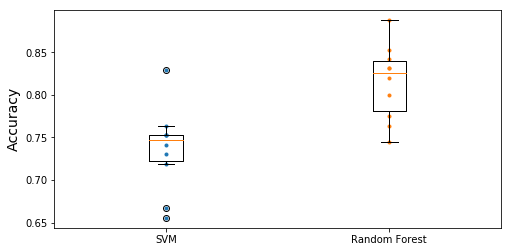

In [71]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()